# CodeStream and partial (ROI) decoding

In previous examples, we demonstrated how to decode/read images using the `nvimgcodec.Decoder.decode` and `nvimgcodec.Decoder.read` APIs to decode from an in-memory encoded stream or a file path, respectively.

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
resources_dir = os.getenv("PYNVIMGCODEC_EXAMPLES_RESOURCES_DIR", "../assets/images/")
img_full_path = os.path.abspath(os.path.join(resources_dir, "cat-1046544_640.jp2"))

from nvidia import nvimgcodec
decoder = nvimgcodec.Decoder()

def display(images, titles=None, figsize=(10, 4)):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=figsize)

    if num_images == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        if titles is not None and i < len(titles):
            ax.set_title(titles[i])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

We can use the `read` API to read and decode an image from a file path:

In [20]:
nv_img1 = decoder.read(img_full_path)

Or we can use the `decode` API to decode from an in-memory encoded stream:

In [21]:
with open(img_full_path, 'rb') as in_file:
    data = in_file.read()
data = nvimgcodec.CodeStream(data)

In [22]:
nv_img2 = decoder.decode(data)

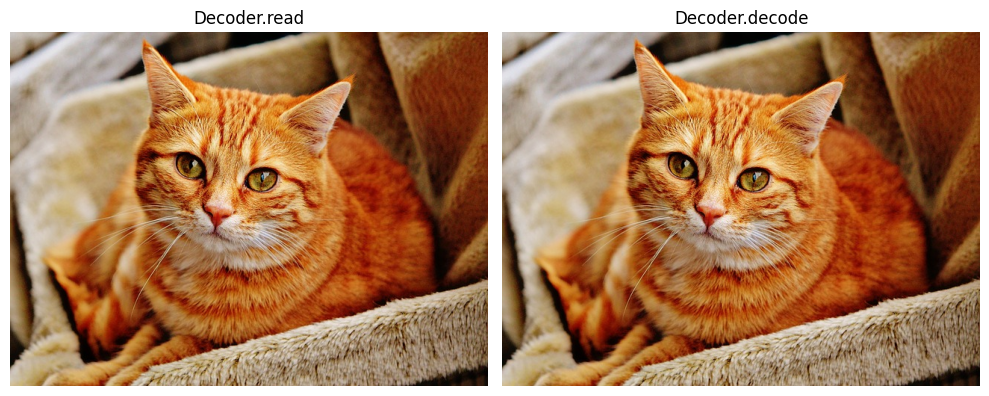

In [23]:
display([nv_img1.cpu(), nv_img2.cpu()], ["Decoder.read", "Decoder.decode"])

These are the simplest methods for interacting with the decoder APIs, which are sufficient when decoding the entire image. However, there are instances where partial decoding, or region-of-interest (ROI) decoding, is necessary. This approach is particularly crucial for handling very large images, such as satellite, aerial, or medical images, which cannot fit into memory or are impractical to process in their entirety.

nvImageCodec enables users to specify an ROI for the decode API by obtaining a sub code stream for the specified ROI. The decode source object includes an encoded stream, which can be an in-memory stream or a file location, and an optional region of interest. Below are examples of using the CodeStream object without specifying a region of interest:

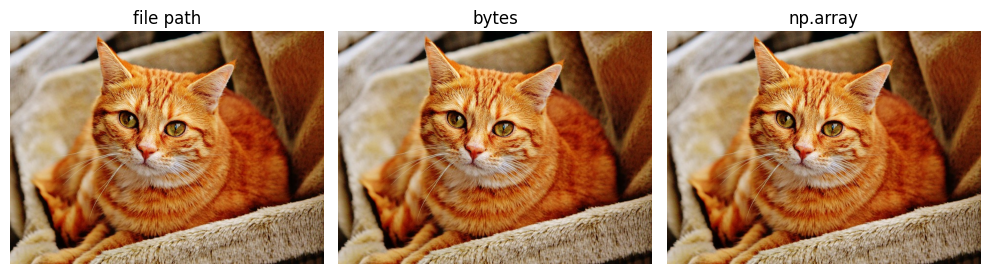

In [24]:
# Decode source is a file path
s1 = nvimgcodec.CodeStream(img_full_path)
# Decode source is a `bytes` instance (in-memory)
read_bytes = open(img_full_path, 'rb').read()
s2 = nvimgcodec.CodeStream(read_bytes)
# Decode source is a numpy array (in-memory)
np_arr = np.fromfile(img_full_path, dtype=np.uint8)
s3 = nvimgcodec.CodeStream(np_arr)

images = [decoder.decode(s).cpu() for s in [s1, s2, s3]]
titles = ['file path', 'bytes', 'np.array']
display(images, titles)

Now we can demonstrate how to set a region of interest for the decode source. For this example, let's first find the dimensions of the image so that we can create a valid ROI.

In [3]:
cs = nvimgcodec.CodeStream(img_full_path)
print(cs.height, 'x', cs.width)

475 x 640


As an example, let's decode two windows from different regions of the image:

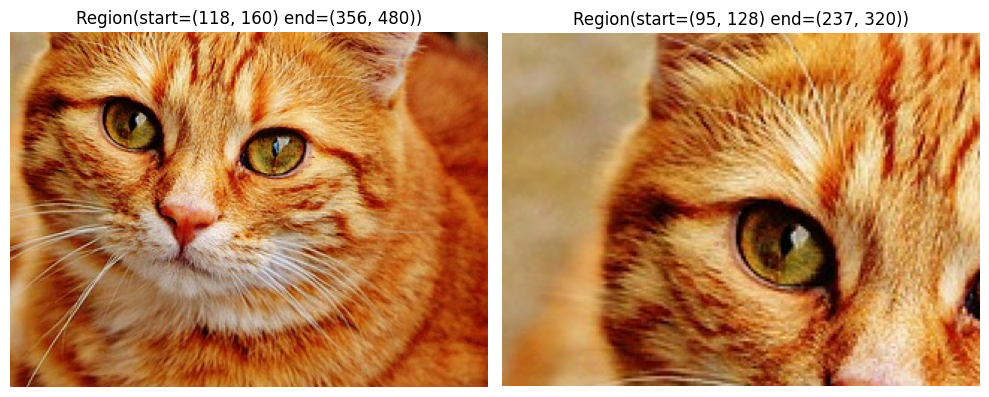

In [ ]:
roi1 = nvimgcodec.Region(int(cs.height * 0.25), int(cs.width * 0.25), int(cs.height * 0.75), int(cs.width * 0.75))
roi2 = nvimgcodec.Region(int(cs.height * 0.2), int(cs.width * 0.2), int(cs.height * 0.5), int(cs.width * 0.5))
decode_sources = [cs.get_sub_code_stream(region=roi) for roi in [roi1, roi2]]
images = [image.cpu() for image in decoder.decode(decode_sources)]
display(images, [str(roi1), str(roi2)])

## Out of bounds region decoding
For gpu accelerated plugins (nvJPEG and nvJPEG2000) you can specify region that is out of bounds of image. Pixels that are not in bounds will be set to a specified fill value (0 by default)

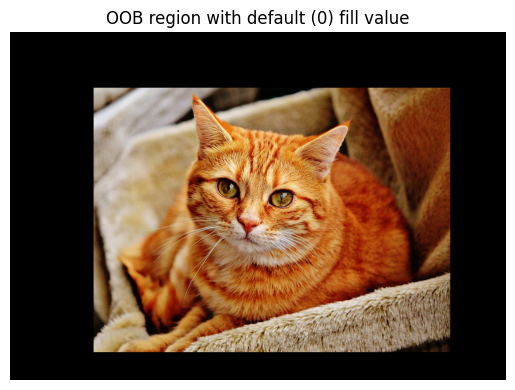

In [ ]:
roi = nvimgcodec.Region(-100, -150, cs.height + 50, cs.width + 100)
image = decoder.decode(cs.get_sub_code_stream(region=roi))
display([image.cpu()], ["OOB region with default (0) fill value"])

You can also specify custom fill value.

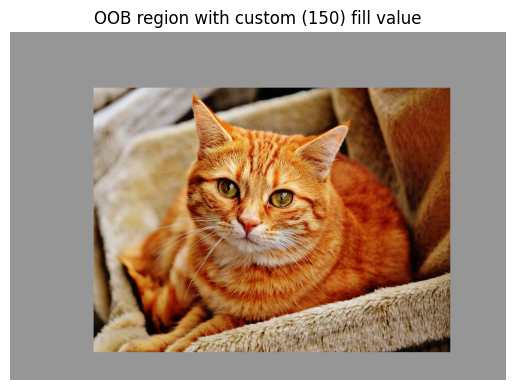

In [ ]:
fill_value = 150
roi = nvimgcodec.Region(-100, -150, cs.height + 50, cs.width + 100, fill_value)
image = decoder.decode(cs.get_sub_code_stream(region=roi))
display([image.cpu()], [f"OOB region with custom ({fill_value}) fill value"])

## Exploiting Tile Geometry

Certain image formats, like TIFF and JPEG2000, allow images to be divided into separate tiles. When requesting an ROI, the alignment between the ROI and these tiles determines how many tiles need to be decoded. In this example, we will demonstrate how to query the image's tile geometry to align the ROI reading pattern with the image tile boundaries.

In [27]:
img_full_path = os.path.abspath(os.path.join(resources_dir, "tiled-cat-1046544_640.jp2"))
cs = nvimgcodec.CodeStream(img_full_path)
print('Image size:', cs.height, 'x', cs.width)
print('Tile size:', cs.tile_height, 'x', cs.tile_width)

Image size: 475 x 640
Tile size: 100 x 100


When processing a given ROI, the decoder must load and decode the corresponding range of tiles. If the ROI boundary does not align with the tile boundary, the entire tile will be decoded, leading to partial data being discarded.

In scenarios where we can determine the access pattern, we may choose to align the tiled reading with the image's tile geometry, thereby optimizing resource usage. The example below demonstrates how to create a grid of ROIs that match the image's tiles.

In [ ]:
decode_srcs = []
nytiles = (cs.height + cs.tile_height - 1) // cs.tile_height
nxtiles = (cs.width + cs.tile_width - 1) // cs.tile_width
for i in range(nytiles):
    row = []
    for j in range(nxtiles):
       start_y = i * cs.tile_height
       end_y = min([(i + 1) * cs.tile_height, cs.height])
       start_x = j * cs.tile_width
       end_x = min([(j + 1) * cs.tile_width, cs.width])
       row.append(
           cs.get_sub_code_stream(region=nvimgcodec.Region(start_y, start_x, end_y, end_x))
       )
    decode_srcs.append(row)

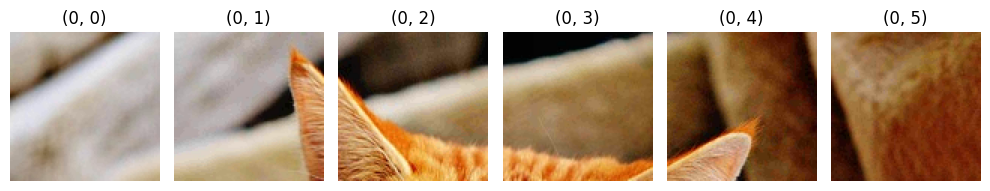

In [29]:
imgs = [img.cpu() for img in decoder.decode(decode_srcs[0][:-1])]
display(imgs, [f"(0, {i})" for i, _ in enumerate(imgs)])

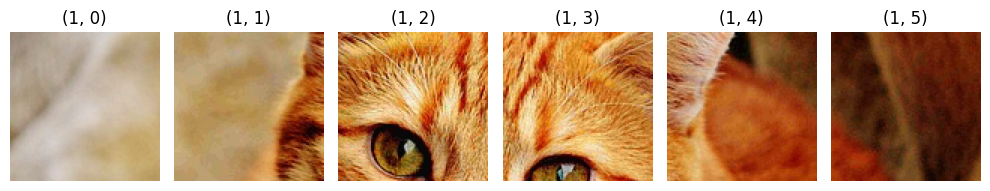

In [30]:
imgs = [img.cpu() for img in decoder.decode(decode_srcs[1][:-1])]
display(imgs, [f"(1, {i})" for i, _ in enumerate(imgs)])